## In this notebook, I'll reload the UNet CNN model trained in khartoum_segmentation_unet_1.ipynb, and demonstrate its use in prediction. I'll also try running Tensorboard and looking at training metrics. 

0. Run the preliminary blocks first.
1. Set up the DataGenerator from notebook 1, as it's the easiest way to get a stream of images to look at.

### 5 blocks to run for setup.

- mount your google drive
- install Miniconda
- update conda
- set up sys.path so new python installs work
- install geospatial stuff and any other libs you need
- import geospatial projects.

In [99]:
# Mount the drive: THIS NEEDS A USER RESPONSE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
# Install conda: shell block
%%capture
%%bash

MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.10.3-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes

In [101]:
# Python block: Set up path to python site-packages
import sys
_ = (sys.path
        .append("/usr/local/lib/python3.7/site-packages"))

In [102]:
# shell block: import additional Python libraries
%%capture
!conda install --channel conda-forge opencv geopandas geojson --yes

In [103]:
# Python import block
import numpy as np
import cv2
import os
import gdal
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random

### Recreate the data generator from notebook 1.



In [104]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [105]:
def get_matching_masks_list(images_list, mask_folder):
  '''
  for use in the custom data generator. 
  Given a list of image chips in a certain order,
  check whether each image chip has a matching mask in the mask_folder,
  and construct the matching list of mask filenames.
  '''

  import re
  masks = []
  filenum_pattern = re.compile(r"img(?P<numbers>[0-9]+)\.tif$")
  for filename in images_list:
    chip_match = filenum_pattern.search(filename)
    if chip_match is None:
      print(f"Warning: Found Unexpected Image Filename in images list, skipping it: {filename}")
      continue
    filenum = int(chip_match.group("numbers"))
    matching_maskfile = os.path.join(mask_folder, f"RGB-PanSharpen_AOI_5_Khartoum_mask{filenum}.tif")
    if not os.path.exists(matching_maskfile):
      print(f"Error: Mask File {matching_maskfile} not found")
      raise FileNotFoundError
    masks.append(matching_maskfile)
  return masks



In [106]:
import gdal
import osgeo.gdalnumeric as gdn

def gdal_get_tensor(image_path, dtype="float32", dim_ordering="channels_last"):
  '''
  Reads image as a tensor
  image_path: path to a gdal-readable color or grayscale image.
  dtype: desired datatype of output tensor
  dim_ordering: "channels_last" (tensorflow standard) or "channels_first" (gdal_standard)
  
  '''
  file  = gdal.Open(image_path)
  bands = [file.GetRasterBand(i) for i in range(1, file.RasterCount + 1)]
  arr = np.array([gdn.BandReadAsArray(band) for band in bands]).astype(dtype)

  # Reorder dimensions, so that channels are last -- standard for tensorflow tensors
  if dim_ordering=="channels_last":
      arr = np.transpose(arr, [1, 2, 0])  
  return arr

In [107]:
# custom DataGenerator
def datagen(img_folder, mask_folder, image_size, batch_size):

  c = 0
  images_list = os.listdir(img_folder) #List of training images
  random.shuffle(images_list)
  # assume you also have a matching list of masks here
  masks_list = get_matching_masks_list(images_list, mask_folder)

  while (True):

    # initialize space for the images and masks in this batch
    img_batch = np.zeros((batch_size, image_size, image_size, 3)).astype('float')
    mask_batch = np.zeros((batch_size, image_size, image_size, 1)).astype('float')

    # put the images and masks into their 4D batch tensors.
    for ii in range(c, c+batch_size): #initially from 0 to 16, c = 0. 

      # Read one image, normalize it, and resize it
      # CJ note 9/27: I'm setting the normalization factor to 2000 to test my theory that normalization problems are causing convergence to fail. 
      # the image values vary, but all seem less than this. 
      train_img = gdal_get_tensor(os.path.join(img_folder, images_list[ii]))/2000.00
      train_img =  cv2.resize(train_img, (image_size, image_size))
      # this adds the image to the image batch, which is a 4-tensor.
      img_batch[ii-c] = train_img #add to array - img[0], img[1], and so on.
                                                   
      # Read one mask, normalize it (? what is the mask value set to? 1!) and resize it
      # when you created these masks, you made them 3-channel by accident -- such a waste of space!
      # work around it!
      train_mask = gdal_get_tensor(masks_list[ii])
      train_mask = cv2.resize(train_mask, (image_size, image_size))
      # The masks are actually not 3-tensors, so we add an extra dimension for parity with train_img dimensions [512 * 512 * 3]
      train_mask = train_mask.reshape(image_size, image_size, 3)

      # keep only the 1st band, which has the data
      # print(np.max(train_mask[:,:,0]))
      # print(np.max(train_mask[:,:,1]))
      # print(np.max(train_mask[:,:,2]))
      train_mask = train_mask[:,:,0]
      train_mask = train_mask.reshape(image_size, image_size, 1)
      mask_batch[ii-c] = train_mask

    # now we've constructed the next image and mask batch.
    # increment the files index by batch_size, and check whether the new c index is greater than the number of files. 
    # if so, reset it to zero and random shuffle the files again.
    c+=batch_size
    if(c+batch_size>=len(images_list)):
      c=0
      random.shuffle(images_list)
                  # print "randomizing again"
    yield img_batch, mask_batch

In [108]:
# function for displaying source, predicted, and true images.
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    the_array = display_list[i]
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    display_img = tf.keras.preprocessing.image.array_to_img(the_array)
    plt.imshow(display_img)
    plt.axis('off')
  plt.show()

### Set up values to pass to the data generator.

First declare the image and batch sizes. We're not training, and I want to feed the prediction one image at a time from the validation directory, so I'll set BATCH_SIZE to 1. 

In [109]:
# Note the SN2 chips are 650 x 650 x 3 (RGB)

val_image_base = '/content/drive/MyDrive/Khartoum/val_frames'
val_mask_base = '/content/drive/MyDrive/Khartoum/val_masks'
IM_SIZE = 512
BATCH_SIZE = 1

### Define the UNet model as in notebook 1.



In [110]:
# define the encoder
base_model = tf.keras.applications.MobileNetV2(input_shape=[IM_SIZE, IM_SIZE, 3], include_top=False)
# this has a huge output but is useful if you haven't seen it. 
# tf.keras.utils.plot_model(base_model, show_shapes=True)

# Use the activations of these 5 layers as skip-connection features in the decoder.
# Dimensions of the layers for 512x512 input are shown alongside.
layer_names = [
    'block_1_expand_relu',   # 256x256x96
    'block_3_expand_relu',   # 128x128x144
    'block_6_expand_relu',   # 64x64x192
    'block_13_expand_relu',  # 32x32x576
    'block_16_project',      # 16x16x320
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the encoder portion of the model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

# create the decoder portion of the model.
# Note: that first value is the number of channels in the upsampled output. 
# the second value is the size of the convolution filter to apply.
# Alongside are tensor dimensions for 512x512 input.
up_stack = [
    upsample(512, 3),  # 16x16 -> 32x32x512
    upsample(256, 3),  # 32x32 -> 64x64x256
    upsample(128, 3),  # 64x64 -> 128x128x128
    upsample(64, 3),   # 128x128 -> 256x256x64
]

In [111]:
def endl():
  print("\n")

def divider():
  print("============================================================\n")


def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[IM_SIZE, IM_SIZE, 3])

  # Downsampling through the model
  # down_stack is a model, and therefore is callable with the inputs to the unet.
  # calling it returns the 5 layers that were included in the down_stack definition.
  # skips is a list of 5 items, each of which is a KerasTensor with the 
  # shape determined by the layer.
  skips = down_stack(inputs)

  # this returns the last layer, to initialize the upsampling.
  x = skips[-1]

  # this reverses the order of the layers in skips
  print("layers in down_stack")

  # python note: 'reversed' results in skip becoming an iterator
  # which can be exhausted, like 'zip' does. So call 'list' on it to get 
  # a list which can be iterated over more than once.
  skips = list(reversed(skips[:-1]))
  for layer in skips:
    print(layer)
  divider()

# at this point, 'skips' is a list of layers with shapes (for an input of dimensions 512x512x3):
# (32,32,576), (64,64, 192), (128, 128, 144), (256, 256, 96) (see output from the "Functional" block in the model diagram).
# And 'up_stack' is a list of transforms converting their inputs to shapes:
# (32, 32, 512), (64, 64, 256), (128, 128, 128), (256, 256, 64).
# see the output when this function is run.
# After concatenating, the results are blocks of this size:
# (32, 32, 1088), (64, 64, 448), (128, 128, 272), (256, 256, 160).
# Confirm in the 'concatenate' blocks of the diagram below.


  # This is the heart of the unet
  # Upsampling and establishing the skip connections.
  # Start the iteration with the final feature layer in 'down_stack' 
  # which is (16, 16, 320).
  # The first call in the iteration upsamples it to (32,32, 512).
  # the 3rd call concatenates this to the 1st layer in 'skips' which is (32, 32, 576).
  print("layers produced by the transforms in up_stack")
  for up, skip in zip(up_stack, skips):
    x = up(x)
    print(x) 
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  divider()

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Compile the model and common sense check dimensions.

In [112]:
OUTPUT_CLASSES = 2 # building and nonbuilding

unet_model_2_1 = unet_model(output_channels=OUTPUT_CLASSES)
unet_model_2_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

layers in down_stack
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 576), dtype=tf.float32, name=None), name='model_6/block_13_expand_relu/Relu6:0', description="created by layer 'model_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 192), dtype=tf.float32, name=None), name='model_6/block_6_expand_relu/Relu6:0', description="created by layer 'model_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 144), dtype=tf.float32, name=None), name='model_6/block_3_expand_relu/Relu6:0', description="created by layer 'model_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 96), dtype=tf.float32, name=None), name='model_6/block_1_expand_relu/Relu6:0', description="created by layer 'model_6'")

layers produced by the transforms in up_stack
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='sequential_12/re_lu_12/Relu:0', description="created by layer 'sequential_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64

### Check what the model does before its weights are set to trained values. We expect it to be crap, and it is. 

In [113]:
def softmax_2(chan0, chan1):
  '''
  channels 0 and 1 are the outputs of the neural net (they are unnormalized, i.e., logits).
  returns the 2nd channel (the building channel) of their softmax.
  '''
  the_mask = np.exp(chan1)/(np.exp(chan1) + np.exp(chan0))
  print(the_mask.shape)
  return the_mask

def create_mask(pred_mask):
  '''
  return the raw values for class 1 (buildings).
  ''' 
  the_mask = softmax_2(pred_mask[:,:,0, tf.newaxis], pred_mask[:,:,1, tf.newaxis])
  return the_mask

  # pred_mask = tf.argmax(pred_mask, axis=-1)
  
  # # tf.argmax produces a NxN tensor
  # # this line makes it NxNx1 
  # pred_mask = pred_mask[..., tf.newaxis]
  # nonzeros = np.sum(pred_mask)
  # print(nonzeros)
  # return pred_mask

def show_prediction(image_batch, mask_batch, model):
  pred_batch = model.predict(image_batch)
  for image, mask, pred in zip(image_batch, mask_batch, pred_batch):
    display([image, mask, create_mask(pred)])
  return

(512, 512, 1)


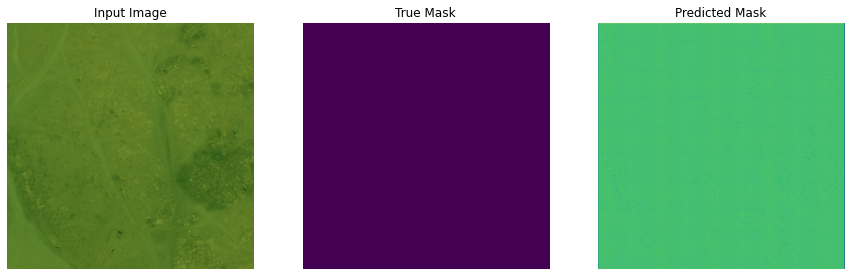

(512, 512, 1)


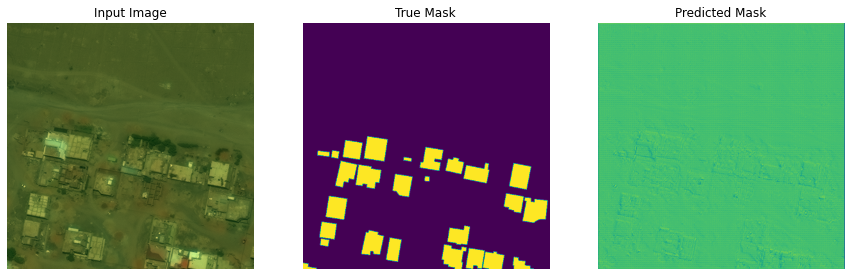

(512, 512, 1)


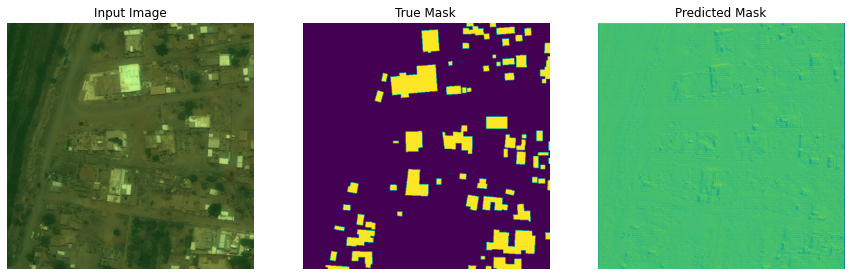

(512, 512, 1)


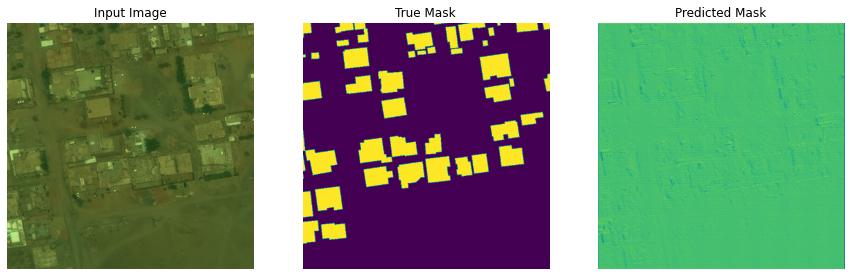

(512, 512, 1)


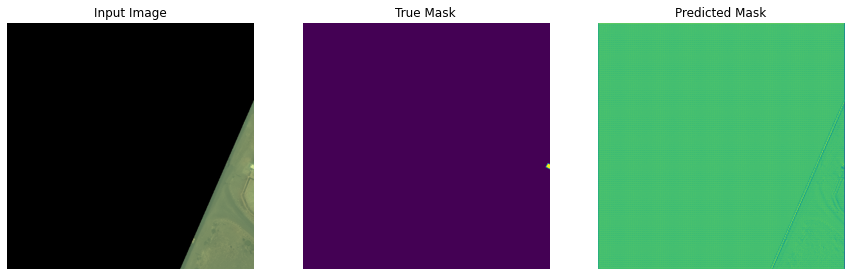

In [114]:
limit = 5
ii = 1
for image, mask in datagen(val_image_base,val_mask_base, IM_SIZE, BATCH_SIZE):
  show_prediction(image, mask, unet_model_2_1)
  ii=ii+1
  if ii>limit: break

### Load the UNet model from the last saved model created in khartoum_segmentation_unet_1.ipynb. 

Here I worked from this tutorial: [Save and Load Models](https://www.tensorflow.org/tutorials/keras/save_and_load).

In [115]:
checkpoint_dir = "/content/drive/MyDrive/unet_train_sgd_bch8_lr02"
checkpoint_path = os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt')

In [116]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)
c6 = checkpoint_path.format(epoch = 6)
c1 = checkpoint_path.format(epoch = 1)
c2 = checkpoint_path.format(epoch=2)

### Predicted masks after checkpoint (epoch) 2. 

(512, 512, 1)


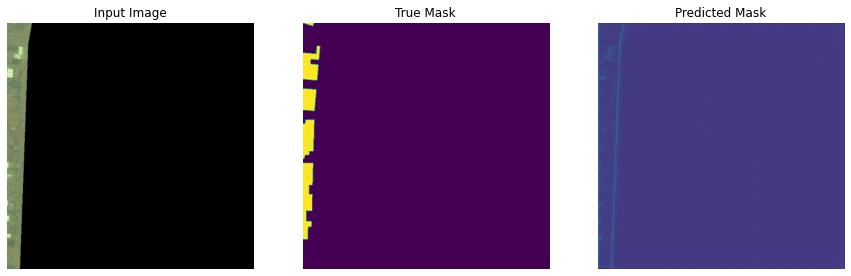

(512, 512, 1)


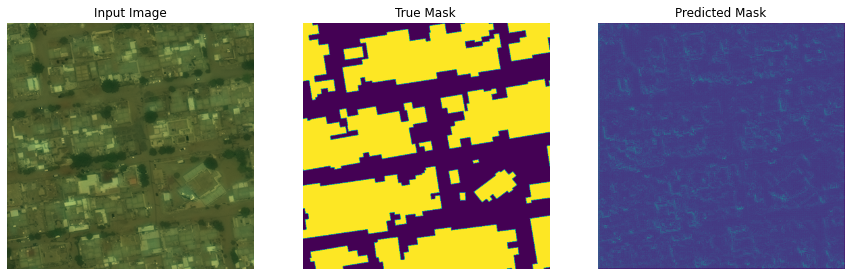

(512, 512, 1)


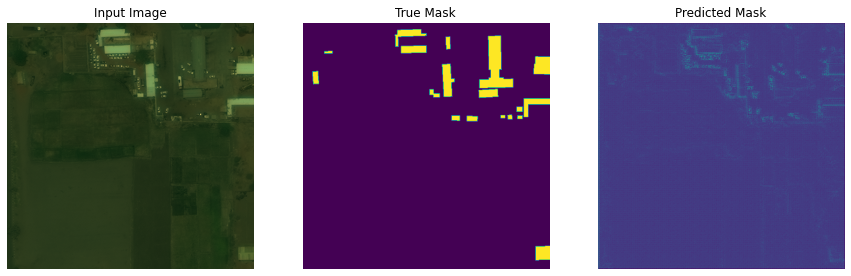

(512, 512, 1)


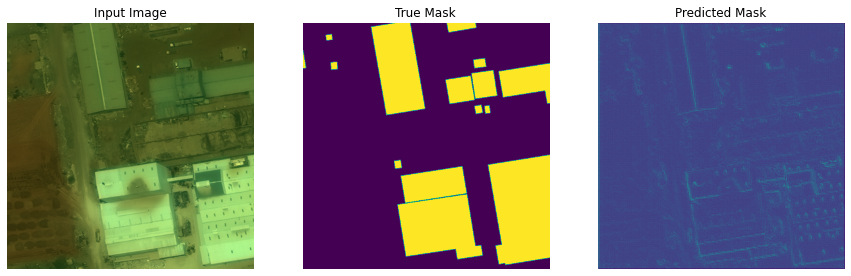

(512, 512, 1)


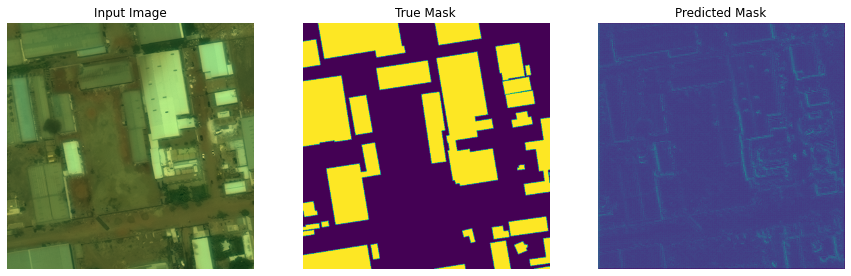

In [117]:
# Load the previously saved weights
unet_model_2_1.load_weights(c2)
limit = 5
ii = 1
for image, mask in datagen(val_image_base,val_mask_base, IM_SIZE, BATCH_SIZE):
  show_prediction(image, mask, unet_model_2_1)
  ii=ii+1
  if ii>limit: break

### Predicted masks after checkpoint 6. 

(512, 512, 1)


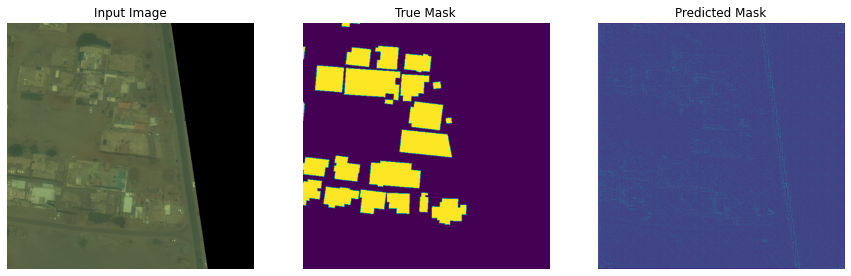

(512, 512, 1)


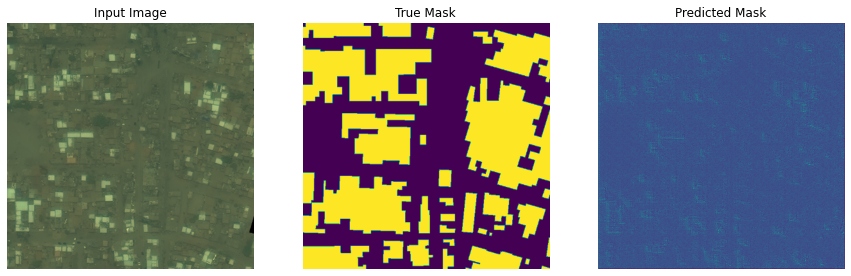

(512, 512, 1)


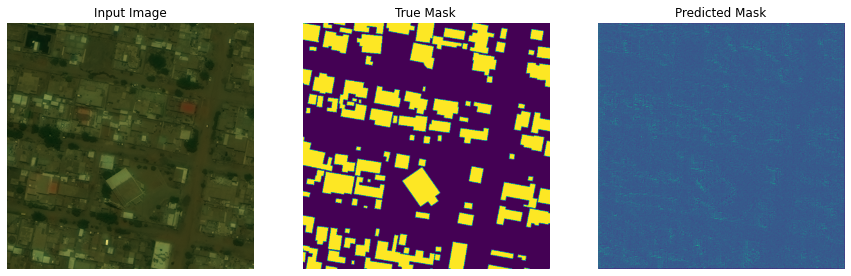

(512, 512, 1)


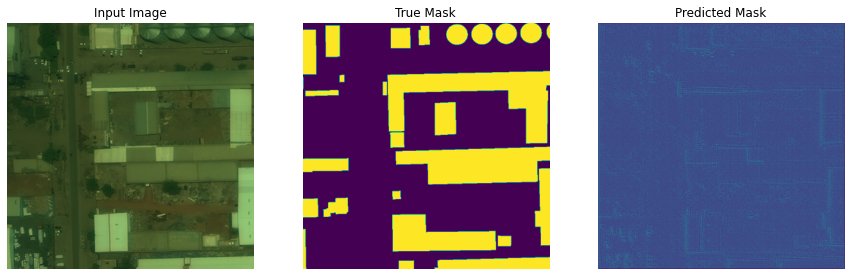

(512, 512, 1)


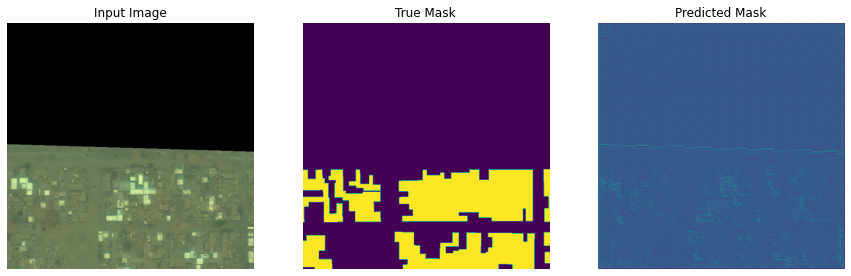

In [118]:
# Load the previously saved weights
unet_model_2_1.load_weights(c6)
limit = 5
ii = 1
for image, mask in datagen(val_image_base,val_mask_base, IM_SIZE, BATCH_SIZE):
  show_prediction(image, mask, unet_model_2_1)
  ii=ii+1
  if ii>limit: break